In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [224]:
np.random.seed(42)
_ = np.random.randn(100)
dates = pd.date_range('2020-01-01', periods=100, freq='D')

y1 = 2 + 5 * _ + np.random.randn(100) + np.arange(100) * 0.5
y2 = -2 + 3 * _ + np.random.randn(100) + np.arange(100) * 0.5
y2[np.random.choice(100, 15, replace=False)] = np.nan

x = pd.Series(y1, index=dates)
y = pd.Series(y2, index=dates)

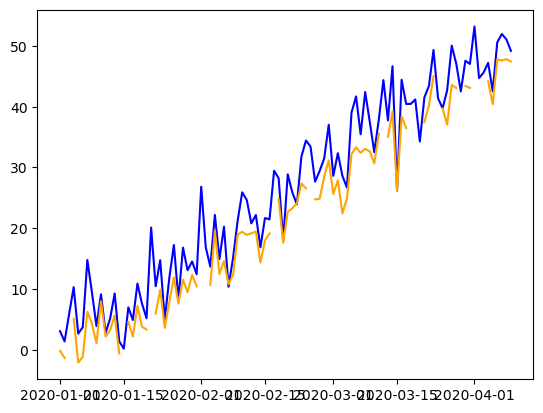

In [225]:
plt.plot(dates, x, label='x', color='blue')
plt.plot(dates, y, label='y', color='orange')

In [107]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def rolling_ewma_regression(y, x, span=30, alpha=1.0):
    y_filled = y.copy()
    preds = pd.Series(index=y.index, dtype=float)
    
    for t in range(span, len(y)):
        y_window = y.iloc[t-span:t]
        x_window = x.iloc[t-span:t]
        
        mask = y_window.notna()
        if mask.sum() < span // 2:  # skip if too sparse
            continue

        w = np.exp(-np.linspace(0, 1, mask.sum()))[::-1]  # exponential decay
        model = Ridge(alpha=alpha, fit_intercept=True)
        model.fit(x_window[mask].values.reshape(-1, 1), y_window[mask].values, sample_weight=w)

        preds.iloc[t] = model.predict([[x.iloc[t]]])[0]
    
    return model, preds


In [118]:
model, res = rolling_ewma_regression( y, x, alpha=15 )

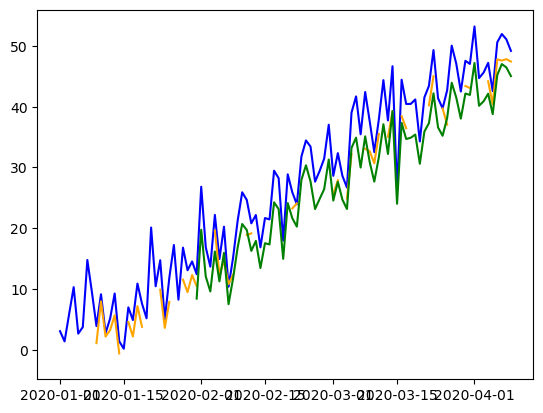

In [119]:
plt.plot(x, label='x', color='blue')
plt.plot(y, label='y', color='orange')
plt.plot(res, label='Predicted y', color='green')

In [120]:
model.coef_, model.intercept_

(array([0.85114162]), 3.1736195046265365)

In [121]:
model.__dict__

{'alpha': 15,
 'fit_intercept': True,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.0001,
 'solver': 'auto',
 'positive': False,
 'random_state': None,
 'n_features_in_': 1,
 'coef_': array([0.85114162]),
 'n_iter_': None,
 'intercept_': 3.1736195046265365}

## Historical Fitting

In [258]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from quantbullet.plot.colors import ColorEnum

class RollingRidgeImputer:
    """
    Rolling Exponential Weighted Ridge Regression.
    This class implements a rolling regression model using Ridge regression with exponential weighting.
    It is designed to handle time series data where the dependent variable (y) may have missing values.
    """
    def __init__(self, span=30, alpha=1.0):
        """
        Parameters
        ----------
        span : int
            The window size for rolling regression.
        alpha : float
            The regularization strength for Ridge regression.
        """
        self.span       = span
        self.alpha      = alpha
        self.coef_      = None
        self.fitted_    = None

        self._raw_y     = None
        self._raw_x     = None

    def fit(self, y: pd.Series, x: pd.Series):
        """
        Fit the model to sparse y and complete x using rolling EW Ridge.

        Parameters
        ----------
        y : pd.Series
            The dependent variable (target).
        x : pd.Series
            The independent variable (predictor).
        """
        assert isinstance( y, pd.Series ) and isinstance( x, pd.Series ), "Inputs must be pandas Series"
        assert y.index.equals(x.index), "x and y must be aligned"
        
        self._raw_y = y.copy()
        self._raw_x = x.copy()

        y_pred = pd.Series( index=y.index, dtype=float )
        coefs = []

        for t in range( self.span, len( y ) ):
            y_window = y.iloc[ t - self.span:t ]
            x_window = x.iloc[ t - self.span:t ]

            mask = y_window.notna()
            if mask.sum() < self.span // 2:
                coefs.append( ( np.nan, np.nan ) )
                continue

            # decay = 3
            # w = np.exp(-np.linspace(0, decay, mask.sum()))[::-1]
            w = np.exp( -np.linspace( 0, 1, mask.sum() ) )[ ::-1 ]
            model = Ridge( alpha=self.alpha, fit_intercept=True )
            model.fit( x_window[ mask ].values.reshape( -1, 1 ), y_window[ mask ].values, sample_weight=w )

            pred = model.predict( [ [ x.iloc[ t ] ] ] )[ 0 ]
            y_pred.iloc[t] = pred
            coefs.append( ( model.intercept_, model.coef_[ 0 ] ) )

        self.fitted_ = y_pred
        self.coef_ = pd.DataFrame( coefs, index=y.index[ self.span: ], columns=[ 'intercept', 'slope' ] )
        return self

    def get_fitted(self):
        """Return predicted y values (NaNs where not available)."""
        return self.fitted_

    def get_coefficients(self):
        """Return DataFrame of (intercept, slope) per day."""
        return self.coef_

    def plot(self):
        """Plot the fitted values and coefficients."""
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
        # self.fitted_.plot(ax=axs[0], label='Fitted y', linewidth=2)

        self._raw_y.plot( ax=axs[0], label='y', color=ColorEnum.BLUE_L3.value, linewidth=2 )
        self._raw_x.plot( ax=axs[0], label='x', color=ColorEnum.GREEN_L3.value, alpha=0.5 )
        self.fitted_.plot( ax=axs[0], label='Predicted y', color=ColorEnum.ORANGE_L3.value, linewidth=2 )

        axs[0].legend(); axs[0].set_title( "Fitted y" )

        self.coef_[['intercept', 'slope']].plot(ax=axs[1])
        axs[1].set_title("Rolling Coefficients")
        plt.tight_layout()
        plt.show()


In [262]:
r = RollingRidgeImputer(span=20, alpha=1)
r.fit(y, x)

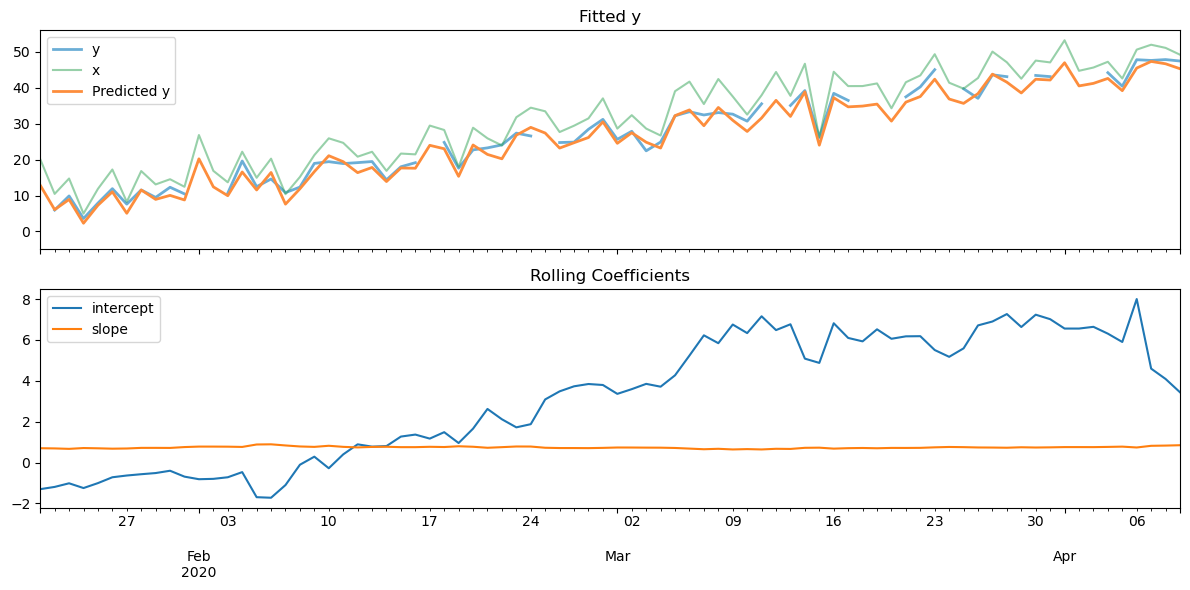

In [263]:
r.plot()

## Smoothing

In [124]:
from scipy.signal import savgol_filter

In [153]:
x_smooth = pd.Series(
    savgol_filter(x, window_length=11, polyorder=2),
    index=x.index
)

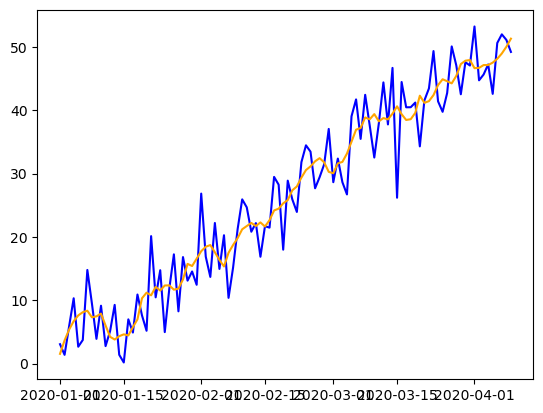

In [154]:
plt.plot(x, label='x', color='blue')
plt.plot(x_smooth, label='Smoothed x', color='orange')

In [163]:
class CLOConstraintEngine:
    def __init__(self, monotonic_pairs=None, band_constraints=None, series_order=None):
        self.monotonic_pairs = monotonic_pairs or []
        self.band_constraints = band_constraints or []
        self.order_rank = {name: i for i, name in enumerate(series_order or [])}
        self.logs = []  # logs of adjustments

    def _prefer_adjust(self, a, b):
        return a if self.order_rank.get(a, 999) > self.order_rank.get(b, 999) else b

    def _log(self, date, typ, series, amount, details):
        self.logs.append({
            "date": date,
            "type": typ,
            "series": series,
            "adjustment": amount,
            "details": details
        })

    def _enforce_monotonic(self, row, lo, hi, date):
        if pd.notna(row[lo]) and pd.notna(row[hi]) and row[lo] > row[hi]:
            target = self._prefer_adjust(lo, hi)
            original = row[target]
            if target == lo:
                row[lo] = row[hi] - 0.01
            elif target == hi:
                row[hi] = row[lo] + 0.01
            self._log(date, "monotonic", target, row[target] - original, f"{lo} < {hi}")

    def _enforce_band(self, row, lo, hi, min_spread, max_spread, date):
        if pd.notna(row[lo]) and pd.notna(row[hi]):
            spread = row[hi] - row[lo]
            if spread < min_spread:
                target = self._prefer_adjust(lo, hi)
                original = row[target]
                if target == lo:
                    row[lo] = row[hi] - min_spread
                elif target == hi:
                    row[hi] = row[lo] + min_spread
                self._log(date, "band_too_narrow", target, row[target] - original, f"{hi} - {lo} < {min_spread}")
            elif spread > max_spread:
                target = self._prefer_adjust(lo, hi)
                original = row[target]
                if target == lo:
                    row[lo] = row[hi] - max_spread
                elif target == hi:
                    row[hi] = row[lo] + max_spread
                self._log(date, "band_too_wide", target, row[target] - original, f"{hi} - {lo} > {max_spread}")

    def apply(self, df: pd.DataFrame) -> pd.DataFrame:
        self.logs.clear()
        df_out = df.copy()

        # Top-down pass: from most senior series
        for date in df.index:
            row = df.loc[date].copy()

            for i in range(len(self.order_rank) - 1):
                higher = list(self.order_rank.keys())[i]
                lower = list(self.order_rank.keys())[i + 1]

                # Monotonic step
                if (higher, lower) in self.monotonic_pairs:
                    self._enforce_monotonic(row, higher, lower, date)

                # Band constraint if exists
                for lo, hi, min_spread, max_spread in self.band_constraints:
                    if (lo, hi) == (higher, lower):
                        self._enforce_band(row, lo, hi, min_spread, max_spread, date)

            df_out.loc[date] = row

        return df_out

    def get_logs(self):
        return pd.DataFrame(self.logs)


In [164]:
import numpy as np
import pandas as pd

np.random.seed(42)
dates = pd.date_range('2024-01-01', periods=60)

# Simulate 4 series: AAA, AA, A, BBB
# Start with ideal monotonic structure + noise
base_curve = np.linspace(150, 300, len(dates))  # base DM trend

smoothed_dms = pd.DataFrame({
    'AAA': base_curve + np.random.normal(0, 3, size=len(dates)),
    'AA':  base_curve + 20 + np.random.normal(0, 3, size=len(dates)),
    'A':   base_curve + 50 + np.random.normal(0, 3, size=len(dates)),
    'BBB': base_curve + 70 + np.random.normal(0, 3, size=len(dates)),
}, index=dates)

# Intentionally inject some violations
smoothed_dms.iloc[10, smoothed_dms.columns.get_loc('AA')] = smoothed_dms.iloc[10]['AAA'] - 10
smoothed_dms.iloc[25, smoothed_dms.columns.get_loc('BBB')] = smoothed_dms.iloc[25]['A'] - 30
smoothed_dms.iloc[40, smoothed_dms.columns.get_loc('AA')] = smoothed_dms.iloc[40]['AAA'] + 100


In [167]:
engine = CLOConstraintEngine(
    monotonic_pairs=[('AAA', 'AA'), ('AA', 'A'), ('A', 'BBB')],
    band_constraints=[('AAA', 'AA', 10, 50), ('AA', 'BBB', 30, 120), ( 'AA', 'A', 5, 100 )],
    series_order=['AAA', 'AA', 'A', 'BBB']
)

adjusted = engine.apply(smoothed_dms)
logs = engine.get_logs()
print(logs.head())


        date             type series  adjustment        details
0 2024-01-11        monotonic     AA   10.010000       AAA < AA
1 2024-01-11  band_too_narrow     AA    9.990000  AA - AAA < 10
2 2024-01-26        monotonic    BBB   30.010000        A < BBB
3 2024-02-10    band_too_wide     AA  -50.000000  AA - AAA > 50
4 2024-02-10        monotonic      A    5.149445         AA < A


Before constraint @ day 10:
AAA    174.033476
AA     164.033476
A      220.771739
BBB    244.084184
Name: 2024-01-11 00:00:00, dtype: float64

After constraint @ day 10:
AAA    174.033476
AA     184.033476
A      220.771739
BBB    244.084184
Name: 2024-01-11 00:00:00, dtype: float64


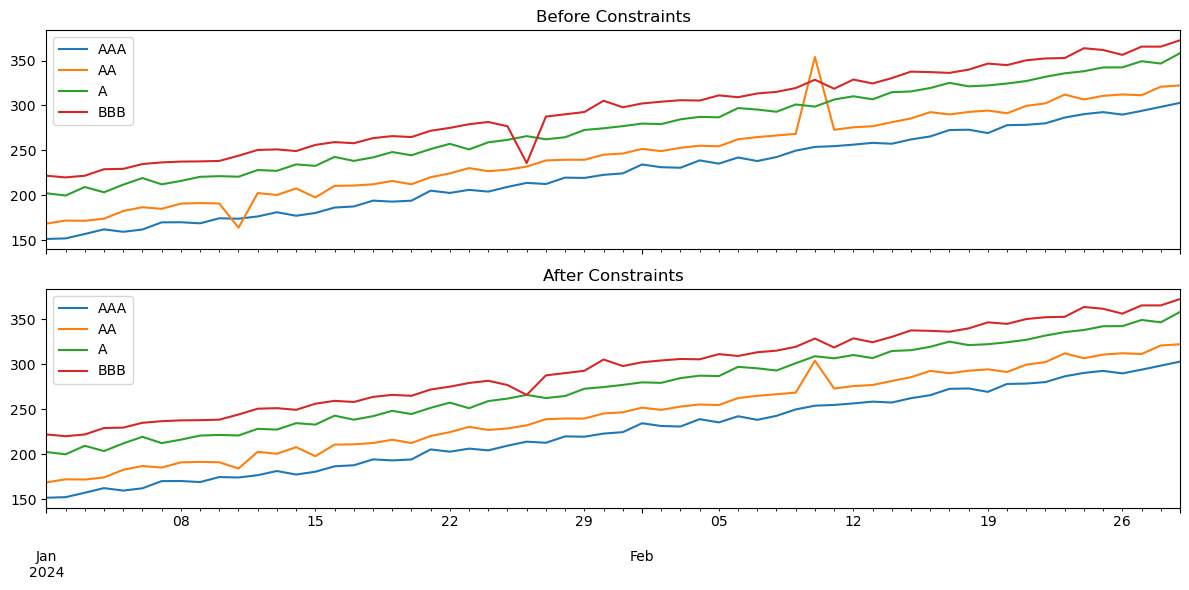

In [168]:
# For inspection: single date
print("Before constraint @ day 10:")
print(smoothed_dms.iloc[10])

print("\nAfter constraint @ day 10:")
print(adjusted.iloc[10])

# Plot full series
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
smoothed_dms.plot(ax=axs[0], title='Before Constraints')
adjusted.plot(ax=axs[1], title='After Constraints')
plt.tight_layout()
plt.show()
